# Extract the spectrum of CTIO Data in May 2017
==================================================================================================

- author : Sylvie Dagoret-Campagne and Jérémy Neveu
- date   : June 1st 2017


- The goal is to extract the spectrum after the rotation.


-1) First the 1 orders are extracted. One must check the rotation is correct

-2) Check the 2 orders are well aligned along X by looking at the transverse profile : if you see two peaks this means the rotation is bad.

-3) For this the central star light must having been turned off.

In [3]:
%%javascript
var kernel = IPython.notebook.kernel;
var thename = window.document.getElementById("notebook_name").innerHTML;
var command = "theNotebook = " + "'"+thename+"'";
kernel.execute(command);

<IPython.core.display.Javascript object>

In [4]:
print theNotebook

Extract_Spectrum


In [5]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

from astropy.modeling import models
from astropy import units as u
from astropy import nddata
from astropy.io import fits
import re
import os, sys
sys.path.append('../../common_tools')

In [6]:
import ccdproc
print 'ccdproc version',ccdproc.__version__

from astropy.modeling import models

ccdproc version 1.2.0


In [7]:
from scipy import stats  
from scipy import ndimage
from datetime import datetime, timedelta
from mpl_toolkits.mplot3d import Axes3D
import scipy.signal

In [8]:
import bottleneck as bn  # numpy's masked median is slow...really slow (in version 1.8.1 and lower)
print 'bottleneck version',bn.__version__

bottleneck version 1.2.0


In [9]:
import photutils
from astropy.stats import sigma_clipped_stats
from photutils import daofind
from photutils import CircularAperture
from astropy.visualization import SqrtStretch
from astropy.visualization.mpl_normalize import ImageNormalize
#from photutils.background import Background2D
from photutils import Background2D, SigmaClip, MedianBackground

In [10]:
%load_ext Cython

In [11]:
from IPython.display import Image, display

In [12]:
import matplotlib
matplotlib.rc('xtick', labelsize=20) 
matplotlib.rc('ytick', labelsize=20) 

In [13]:
# to enlarge the sizes
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (4, 4),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
plt.rcParams.update(params)

In [14]:
############################################################################
def ensure_dir(f):
    d = os.path.dirname(f)
    if not os.path.exists(f):
        os.makedirs(f)
#########################################################################

In [15]:
def subplots_adjust(*args, **kwargs):
    """
    call signature::

      subplots_adjust(left=None, bottom=None, right=None, top=None,
                      wspace=None, hspace=None)

    Tune the subplot layout via the
    :class:`matplotlib.figure.SubplotParams` mechanism.  The parameter
    meanings (and suggested defaults) are::

      left  = 0.125  # the left side of the subplots of the figure
      right = 0.9    # the right side of the subplots of the figure
      bottom = 0.1   # the bottom of the subplots of the figure
      top = 0.9      # the top of the subplots of the figure
      wspace = 0.2   # the amount of width reserved for blank space between subplots
      hspace = 0.2   # the amount of height reserved for white space between subplots

    The actual defaults are controlled by the rc file
    """
    fig = gcf()
    fig.subplots_adjust(*args, **kwargs)
    draw_if_interactive()

### Output directory for images generated in the notebook view (not true fits images)

In [16]:
dir_top_images="images_notebooks/"+theNotebook ### Top directory to save images

In [17]:
ensure_dir(dir_top_images) # create that directory

### Input fits file

In [18]:
inputdir="./rotated_fitsimages"
MIN_IMGNUMBER=6
MAX_IMGNUMBER=10
object_name='HD111980 June 1st 2017'
SelectTagRe='^rotimg_20170601_([0-9]+).fits$' # regular expression to select the file
SearchTagRe='^rotimg_20170601_[0-9]+.fits$'
NBIMGPERROW=2

### output fits file

In [19]:
outputdir="./spectrum_fitsspec"

In [20]:
ensure_dir(outputdir)

## Location of corrected images
----------------------------------

In [21]:
input_filelist=os.listdir(inputdir) 

In [22]:
if '.DS_Store' in input_filelist:
    input_filelist.remove('.DS_Store')
input_filelist=np.array(input_filelist)

In [23]:
input_filelist[:5]
print len(input_filelist)

5


In [24]:
indexes_files= [] # global list
filelist_fitsimages= []  # global list

In [25]:
#%%cython

import numpy as np
import re

def MakeFileList(inputdir,input_filelist):
    """
    MakeFileList : Make The List of files to open
    =============
    """
    
#    import numpy as np
#    import re
    indexes_files= [] # global list
    filelist_fitsimages= []  # global list

    for file in input_filelist: # loop on directories, one per image       
            filename=inputdir+'/'+file
            if re.search('.*fits$',filename):  #example of filename filter
                num_str=re.findall(SelectTagRe,file)[0]
                index=int(num_str)
                filelist_fitsimages.append(filename)
                indexes_files.append(index)
    return indexes_files, filelist_fitsimages

In [26]:
indexes_files, filelist_fitsimages=MakeFileList(inputdir,input_filelist)   # Make the list

In [27]:
indexes_files=np.array(indexes_files)
filelist_fitsimages=np.array(filelist_fitsimages)

In [28]:
print indexes_files

[ 6  7  8  9 10]


In [29]:
sorted_indexes=np.argsort(indexes_files) # sort the file indexes

In [30]:
sorted_numbers=indexes_files[sorted_indexes]

In [31]:
print sorted_indexes

[0 1 2 3 4]


In [32]:
#sorted_files= [filelist_fitsimages[index] for index in sorted_indexes] # sort files
sorted_files=filelist_fitsimages[sorted_indexes]

In [33]:
#sorted_files

## Build full filename
----------------------------

In [34]:
sorted_filenames=[]
for file in sorted_files:
    #fullfilename=os.path.join(inputdir,file)
    fullfilename=file
    sorted_filenames.append(fullfilename)

In [35]:
#sorted_filenames=np.array(sorted_filenames)
sorted_filenames=np.copy(sorted_files)

In [36]:
print sorted_filenames.shape

(5,)


## Acces to data of  images
----------------------------------

In [37]:
all_dates = []
all_airmass = []
all_images = []
all_titles = []
all_header = []
all_img = []
all_filt= []

In [38]:
%%cython

import numpy as np
from astropy.io import fits

def BuildImages(sorted_filenames,sorted_numbers,object_name):
    """
    BuildRawImages
    ===============
    """

    
    all_dates = []
    all_airmass = []
    all_images = []
    all_titles = []
    all_header = []
    all_expo = []
    all_filt= []
   
    NBFILES=sorted_filenames.shape[0]

    for idx in range(NBFILES):  
        
        file=sorted_filenames[idx]    
        
        hdu_list=fits.open(file)
        header=hdu_list[0].header
        #print header
        date_obs = header['DATE-OBS']
        airmass = header['AIRMASS']
        expo = header['EXPTIME']
        filters = header['FILTERS']
        num=sorted_numbers[idx]
        title=object_name+" z= {:3.2f} Nb={}".format(float(airmass),num)
        image_corr=hdu_list[0].data
        image=image_corr
        
        all_dates.append(date_obs)
        all_airmass.append(float(airmass))
        all_images.append(image)
        all_titles.append(title)
        all_header.append(header)
        all_expo.append(expo)
        all_filt.append(filters)
        hdu_list.close()
        
    return all_dates,all_airmass,all_images,all_titles,all_header,all_expo,all_filt

In [39]:
all_dates,all_airmass,all_images,all_titles,all_header,all_expo,all_filt=BuildImages(sorted_files,sorted_numbers,object_name)

## Show images
-----------------------

In [40]:
len(all_images)

5

In [41]:
%%cython
import numpy as np
import matplotlib.pyplot as plt
import os
    
def ShowImages(all_images,all_titles,object_name,dir_top_images,all_filt):
    """
    ShowRawImages: Show the raw images without background subtraction
    ==============
    It returns the x0, where the maximum occurs in the image
    """
    NBIMGPERROW=2
    NBIMAGES=len(all_images)
    MAXIMGROW=int(NBIMAGES/NBIMGPERROW)+1
    thex0 = []
  
    f, axarr = plt.subplots(MAXIMGROW,NBIMGPERROW,figsize=(25,4*MAXIMGROW))
    f.tight_layout()
    for index in np.arange(0,NBIMAGES):
        ix=index%NBIMGPERROW
        iy=index/NBIMGPERROW
        xprofile=np.sum(all_images[index],axis=0)
        x0=np.where(xprofile==xprofile.max())[0][0]
        thex0.append(x0)
        im=axarr[iy,ix].imshow(all_images[index],origin='lower',cmap='rainbow',vmin=0,vmax=800)
        axarr[iy,ix].set_title(all_titles[index])
        axarr[iy,ix].grid(color='white', ls='solid')
        axarr[iy,ix].text(1000.,275.,all_filt[index],verticalalignment='bottom', horizontalalignment='center',color='yellow', fontweight='bold',fontsize=16)
        
    title='Images of {}'.format(object_name)
    plt.suptitle(title,size=16)
    
    figfilename=os.path.join(dir_top_images,'intput_images.pdf')
    plt.savefig(figfilename)  
    
    return thex0

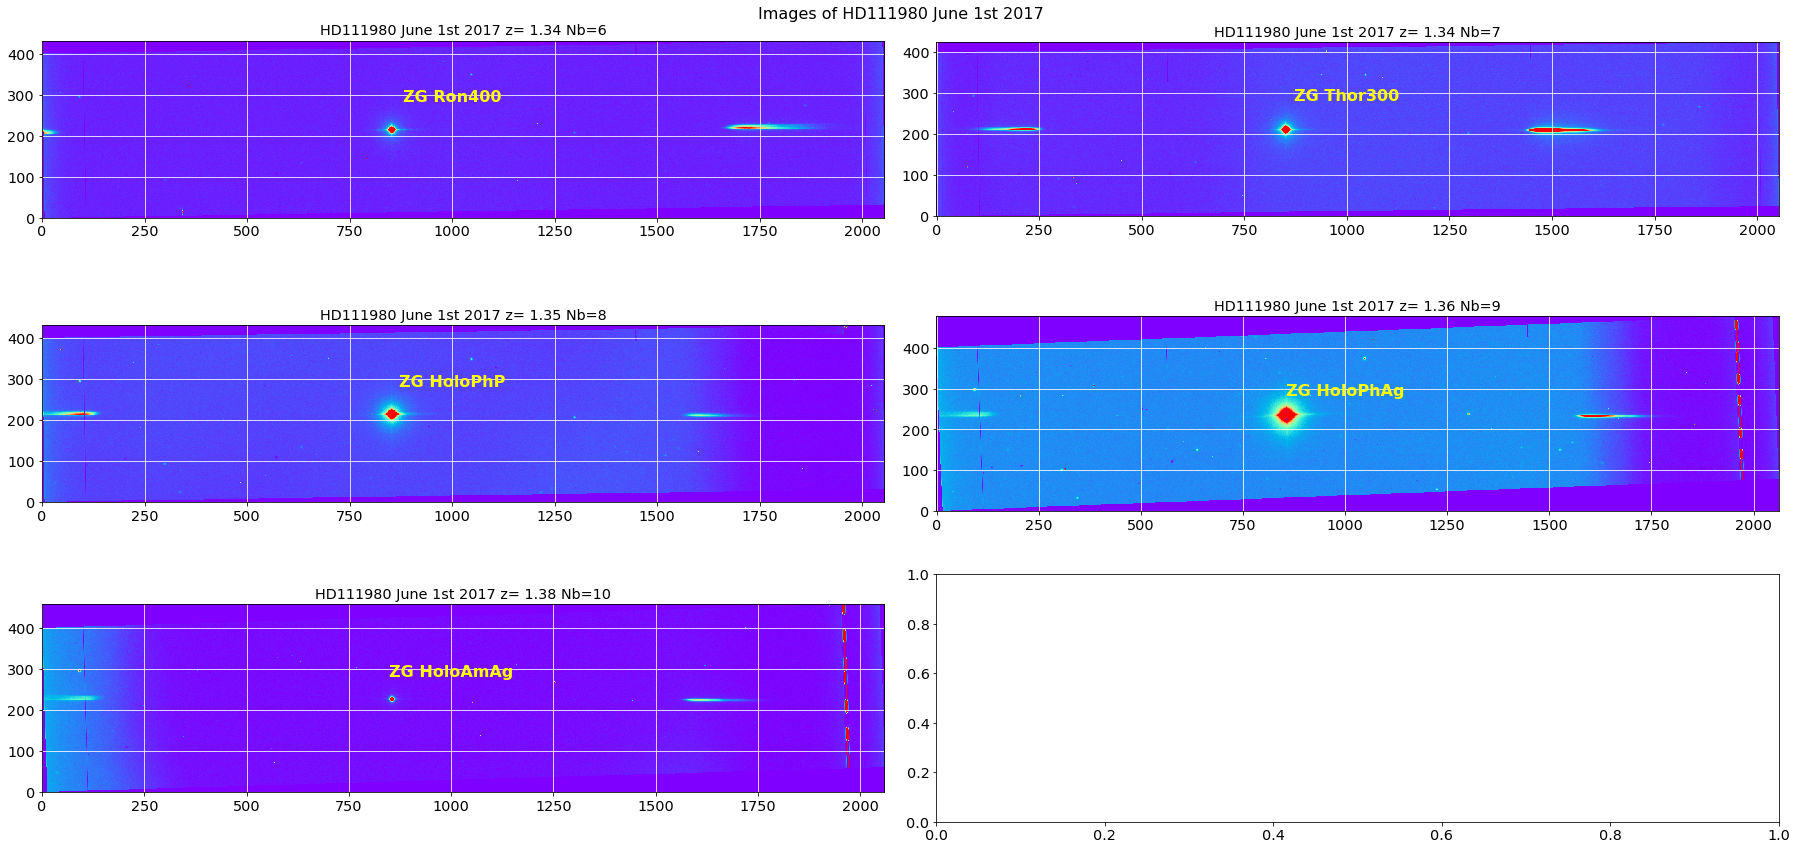

In [42]:
thex0=ShowImages(all_images,all_titles,object_name,dir_top_images,all_filt)

In [43]:
print thex0

[852, 851, 1958, 1958, 1968]


In [44]:
%%cython
import numpy as np
import matplotlib.pyplot as plt
import os


central_positions = np.loadtxt('cut_fitsimages/star_centroids.txt')
thex0 = central_positions.T[1].astype(int)
print thex0
they0 = central_positions.T[0].astype(int)
print they0


def ShowOneOrder(all_images,all_titles,thex0,object_name,all_expo,dir_top_images,figname):
    """
    ShowRawImages: Show the raw images without background subtraction
    ==============
    """
    NBIMGPERROW=2
    NBIMAGES=len(all_images)
    MAXIMGROW=int(NBIMAGES/NBIMGPERROW)+1
    f, axarr = plt.subplots(MAXIMGROW,NBIMGPERROW,figsize=(25,5*MAXIMGROW))
    f.tight_layout()
    for index in np.arange(0,NBIMAGES):
        
        print index, 'exposition time = ',all_expo[index] 
        
        ix=index%NBIMGPERROW
        iy=index/NBIMGPERROW
        full_image=np.copy(all_images[index])
        
        if(all_expo[index]<=0 ): #special case of the first image
            reduc_image=full_image[150:250,thex0[index]+250:min(2048,thex0[index]+1200)]  
        else:
            reduc_image=full_image[150:250,thex0[index]+250:min(2048,thex0[index]+1200)]/all_expo[index] 

            
        X,Y=np.meshgrid(np.arange(0,reduc_image.shape[1]),np.arange(reduc_image.shape[0]))
        im = axarr[iy,ix].pcolormesh(X,Y,reduc_image, cmap='rainbow',vmin=0,vmax=50)
        #axarr[iy,ix].colorbar(im, orientation='vertical')
        axarr[iy,ix].axis([X.min(), X.max(), Y.min(), Y.max()]); axarr[iy,ix].grid(True)
        
        axarr[iy,ix].set_title(all_titles[index])
        
    
    title='Images of {}'.format(object_name)
    plt.suptitle(title,size=16)
    figfilename=os.path.join(dir_top_images,figname)
    #plt.savefig(figfilename) 

[848 848 848 849 848]
[537 539 537 537 537]


0 exposition time =  60.0
1 exposition time =  60.0
2 exposition time =  60.0
3 exposition time =  120.0
4 exposition time =  120.0


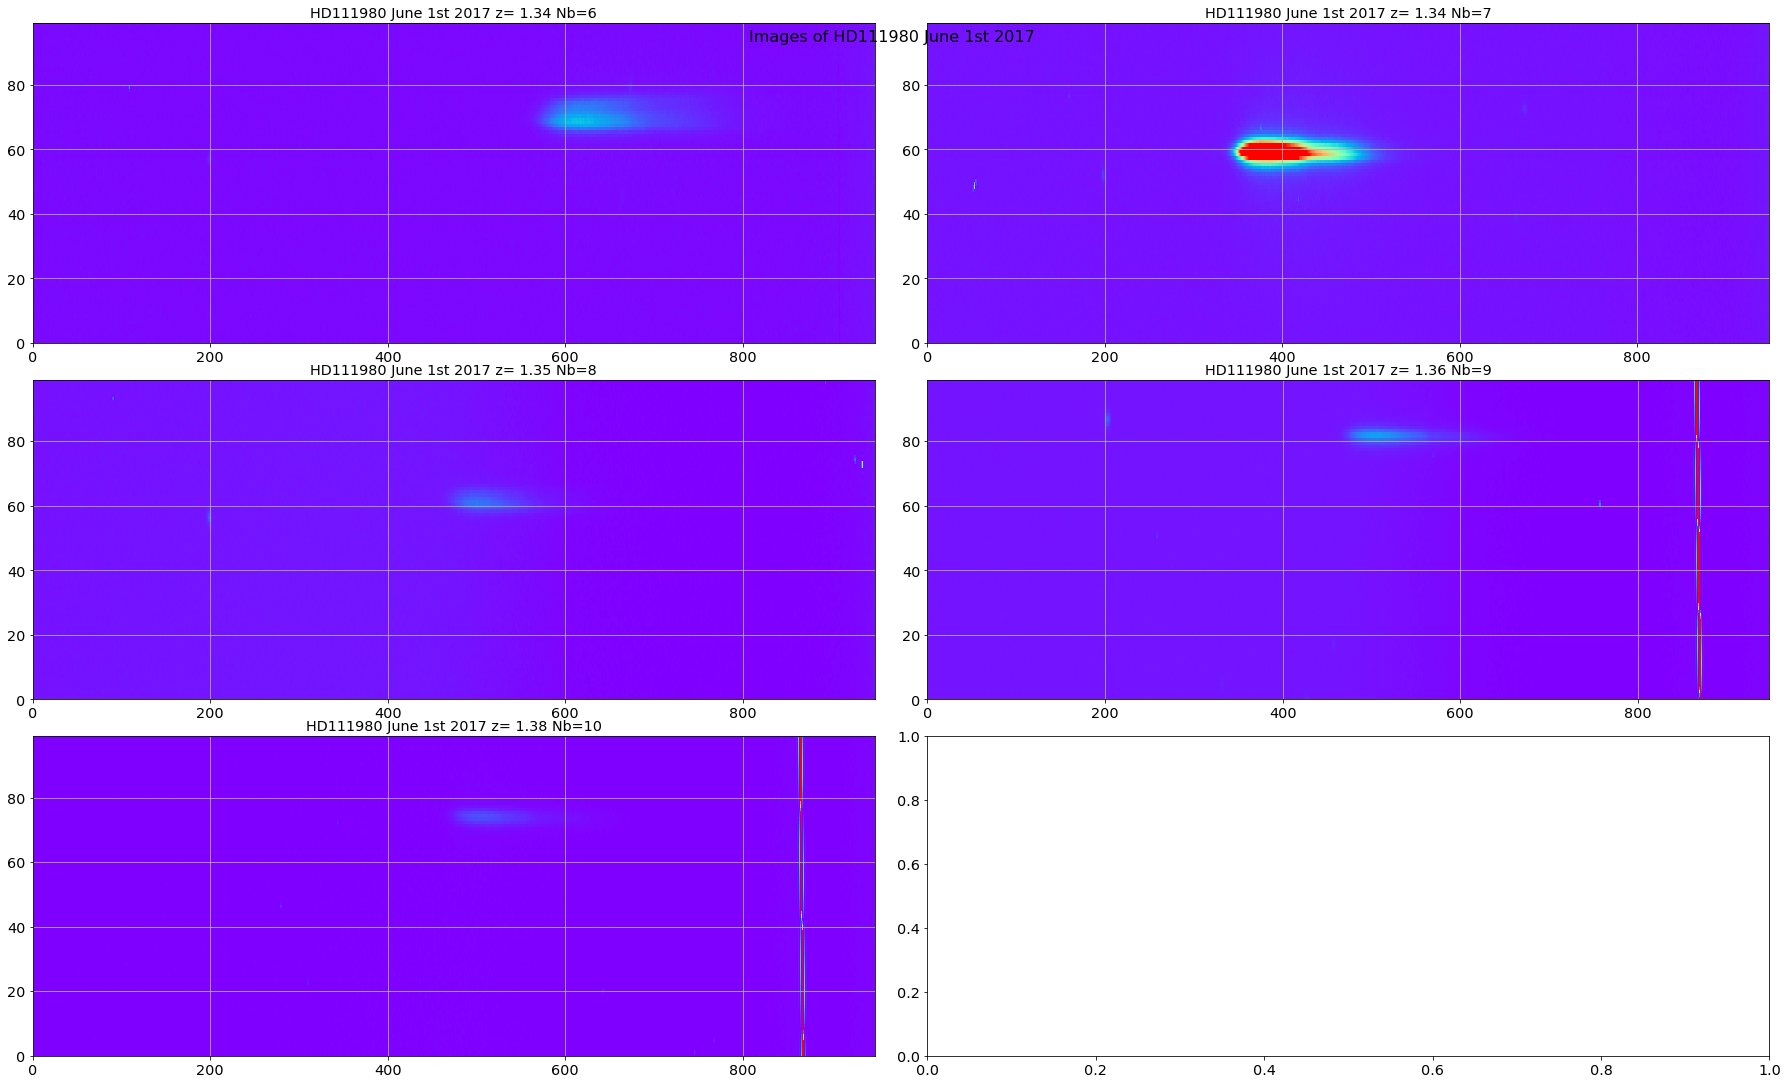

In [45]:
ShowOneOrder(all_images,all_titles,thex0,object_name,all_expo,dir_top_images,'firstorderright.pdf')

### Shows the transverse profile

In [46]:
DeltaX=600
w=20
ws=70

In [47]:
%%cython
import numpy as np
import matplotlib.pyplot as plt
import os

def ShowTransverseProfile(all_images,thex0,all_titles,object_name,all_expo,dir_top_images):
    """
    ShowTransverseProfile: Show the raw images without background subtraction
    =====================
    The goal is to see in y, where is the spectrum maximum. Returns they0
    
    """
    NBIMGPERROW=2
    NBIMAGES=len(all_images)
    MAXIMGROW=int(NBIMAGES/NBIMGPERROW)+1

    ### Criteria for spectrum region selection
    DeltaX=1000
    w=20
    ws=80
    Dist=4*w
    
    thespectra= []
    thespectraUp=[]
    thespectraDown=[]
    
    they0 = []
    
    f, axarr = plt.subplots(MAXIMGROW,NBIMGPERROW,figsize=(25,4*MAXIMGROW))
    f.tight_layout()
    for index in np.arange(0,NBIMAGES):
        ix=index%NBIMGPERROW
        iy=index/NBIMGPERROW
        data=np.copy(all_images[index])
        
        data[:,thex0[index]-100:thex0[index]+100]=0 ## TURN OFF CENTRAL STAR
        
        if(all_expo[index]<=0):            
            yprofile=np.sum(data,axis=1)
        else:
            yprofile=np.sum(data,axis=1)/all_expo[index]
            
            
        ymin=1
        ymax=yprofile.max()
        y0=np.where(yprofile==ymax)[0][0]
        they0.append(y0)
        #y0 = they0[index]
        #im=axarr[iy,ix].imshow(data,vmin=-10,vmax=50)
        axarr[iy,ix].semilogy(yprofile)
        axarr[iy,ix].semilogy([y0,y0],[ymin,ymax],'r-')
        axarr[iy,ix].semilogy([y0-w,y0-w],[ymin,ymax],'k-')
        axarr[iy,ix].semilogy([y0+w,y0+w],[ymin,ymax],'k-')
        
        ##########################################################
        #### Here extract the spectrum around the central star
        #####   Take the sum un bins along y
        #############################################################
        
        spectrum2D=np.copy(data[y0-w:y0+w,:])
        xprofile=np.sum(spectrum2D,axis=0)

        
        ### Lateral bands to remove sky background
        ### ---------------------------------------
        spectrum2DUp=np.copy(data[y0-w+Dist:y0+w+Dist,:])
        xprofileUp=np.median(spectrum2DUp,axis=0)*2.*float(w)

        spectrum2DDown=np.copy(data[y0-w-Dist:y0+w-Dist,:])
        xprofileDown=np.median(spectrum2DDown,axis=0)*2.*float(w)
        
        
        if(all_expo[index]<=0):
            thespectra.append(xprofile)
            thespectraUp.append(xprofileUp)
            thespectraDown.append(xprofileDown)
        else:  ################## HERE I NORMALISE WITH EXPO TIME ####################################
            thespectra.append(xprofile/all_expo[index])
            thespectraUp.append(xprofileUp/all_expo[index]) 
            thespectraDown.append(xprofileDown/all_expo[index]) 

        axarr[iy,ix].set_title(all_titles[index])
        axarr[iy,ix].grid(True)
    title='Spectrum tranverse profile '.format(object_name)
    plt.suptitle(title,size=16)
    
    figfilename=os.path.join(dir_top_images,'transverse_profile.pdf')
    plt.savefig(figfilename)  
    
    return thespectra,thespectraUp,thespectraDown,they0

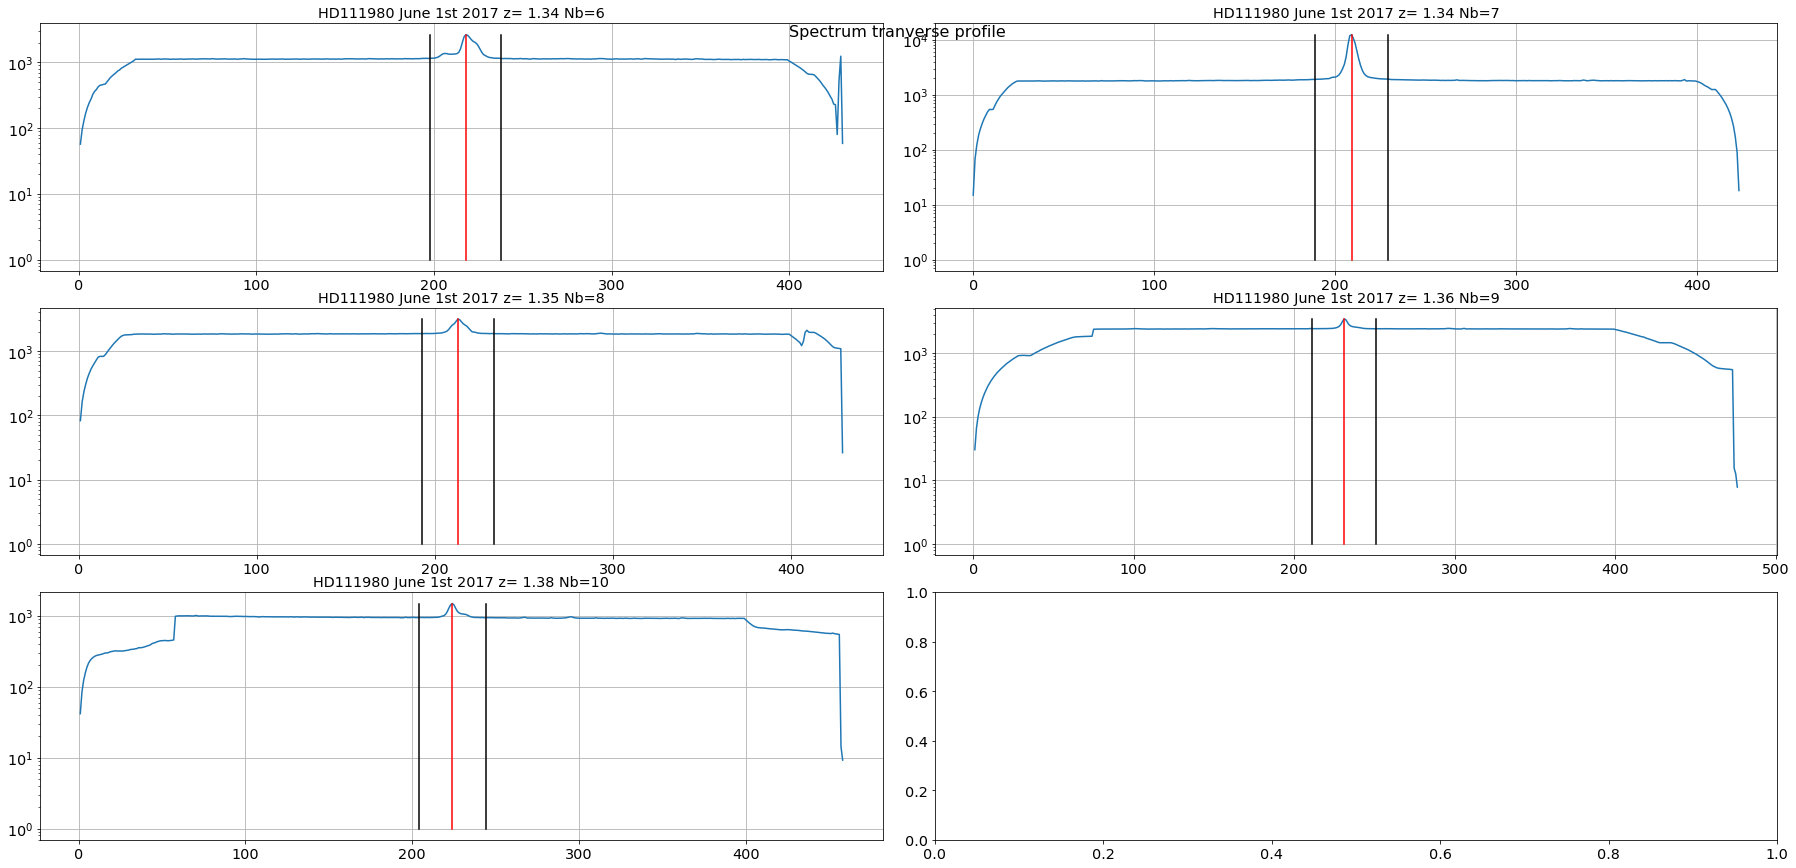

In [48]:
thespectra,thespectraUp,thespectraDown,they0=ShowTransverseProfile(all_images,thex0,all_titles,object_name,all_expo,dir_top_images)

In [49]:
print they0

[218, 209, 213, 231, 224]


In [50]:
%%cython
import numpy as np
import matplotlib.pyplot as plt
import os

def ShowRightOrder(all_images,thex0,they0,all_titles,object_name,all_expo,dir_top_images):
    """
    ShowRawImages: Show the raw images without background subtraction
    ==============
    """
    NBIMGPERROW=2
    NBIMAGES=len(all_images)
    MAXIMGROW=int(NBIMAGES/NBIMGPERROW)+1
    f, axarr = plt.subplots(MAXIMGROW,NBIMGPERROW,figsize=(25,10))
    f.tight_layout()
    for index in np.arange(0,NBIMAGES):
        ix=index%NBIMGPERROW
        iy=index/NBIMGPERROW
        full_image=np.copy(all_images[index])
        x_0=thex0[index]
        y_0=they0[index]

        reduc_image=full_image[y_0-20:y_0+20,x_0+100:2000]/all_expo[index]
        
        X,Y=np.meshgrid(np.arange(0,reduc_image.shape[1]),np.arange(reduc_image.shape[0]))
        im = axarr[iy,ix].pcolormesh(X,Y,reduc_image, cmap='rainbow',vmin=0,vmax=100)
        #axarr[iy,ix].colorbar(im, orientation='vertical')
        axarr[iy,ix].axis([X.min(), X.max(), Y.min(), Y.max()]); axarr[iy,ix].grid(True)
        
        axarr[iy,ix].set_title(all_titles[index])
        
    
    title='Right part of spectrum of {} '.format(object_name)
    plt.suptitle(title,size=16)
    figfilename=os.path.join(dir_top_images,'rightorder.pdf')
    
    #plt.savefig(figfilename)  

In [51]:
%%cython
import numpy as np
import matplotlib.pyplot as plt
import os

def ShowLeftOrder(all_images,thex0,they0,all_titles,object_name,all_expo,dir_top_images):
    """
    ShowRawImages: Show the raw images without background subtraction
    ==============
    """
    NBIMGPERROW=2
    NBIMAGES=len(all_images)
    MAXIMGROW=int(NBIMAGES/NBIMGPERROW)+1
    #thex0 = []
    f, axarr = plt.subplots(MAXIMGROW,NBIMGPERROW,figsize=(25,10))
    f.tight_layout()

    for index in np.arange(0,NBIMAGES):
        ix=index%NBIMGPERROW
        iy=index/NBIMGPERROW
        full_image=np.copy(all_images[index])
        x_0=thex0[index]
        y_0=they0[index]
        
        
        reduc_image=full_image[y_0-20:y_0+20,0:x_0-100]/all_expo[index] 

        X,Y=np.meshgrid(np.arange(0,reduc_image.shape[1]),np.arange(reduc_image.shape[0]))
        im = axarr[iy,ix].pcolormesh(X,Y,reduc_image, cmap='rainbow',vmin=0,vmax=100)
        #axarr[iy,ix].colorbar(im, orientation='vertical')
        axarr[iy,ix].axis([X.min(), X.max(), Y.min(), Y.max()]); axarr[iy,ix].grid(True)
        
        axarr[iy,ix].set_title(all_titles[index])
        
    
    title='Left part of spectrum of '.format(object_name)
    plt.suptitle(title,size=16)
    figfilename=os.path.join(dir_top_images,'leftorder.pdf')
    #plt.savefig(figfilename)  

### Right order

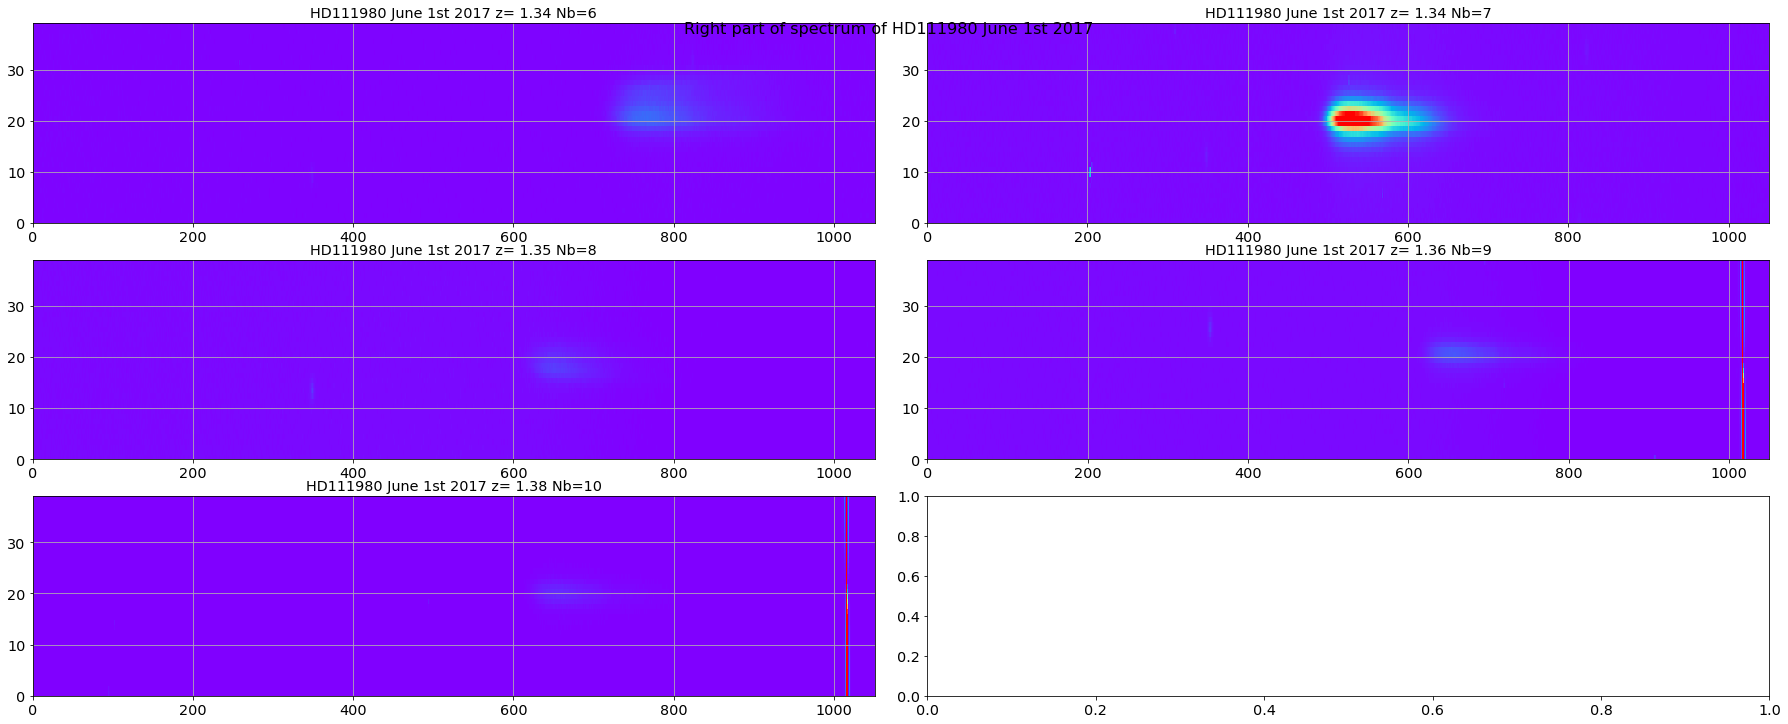

In [52]:
ShowRightOrder(all_images,thex0,they0,all_titles,object_name,all_expo,dir_top_images)

### Left order

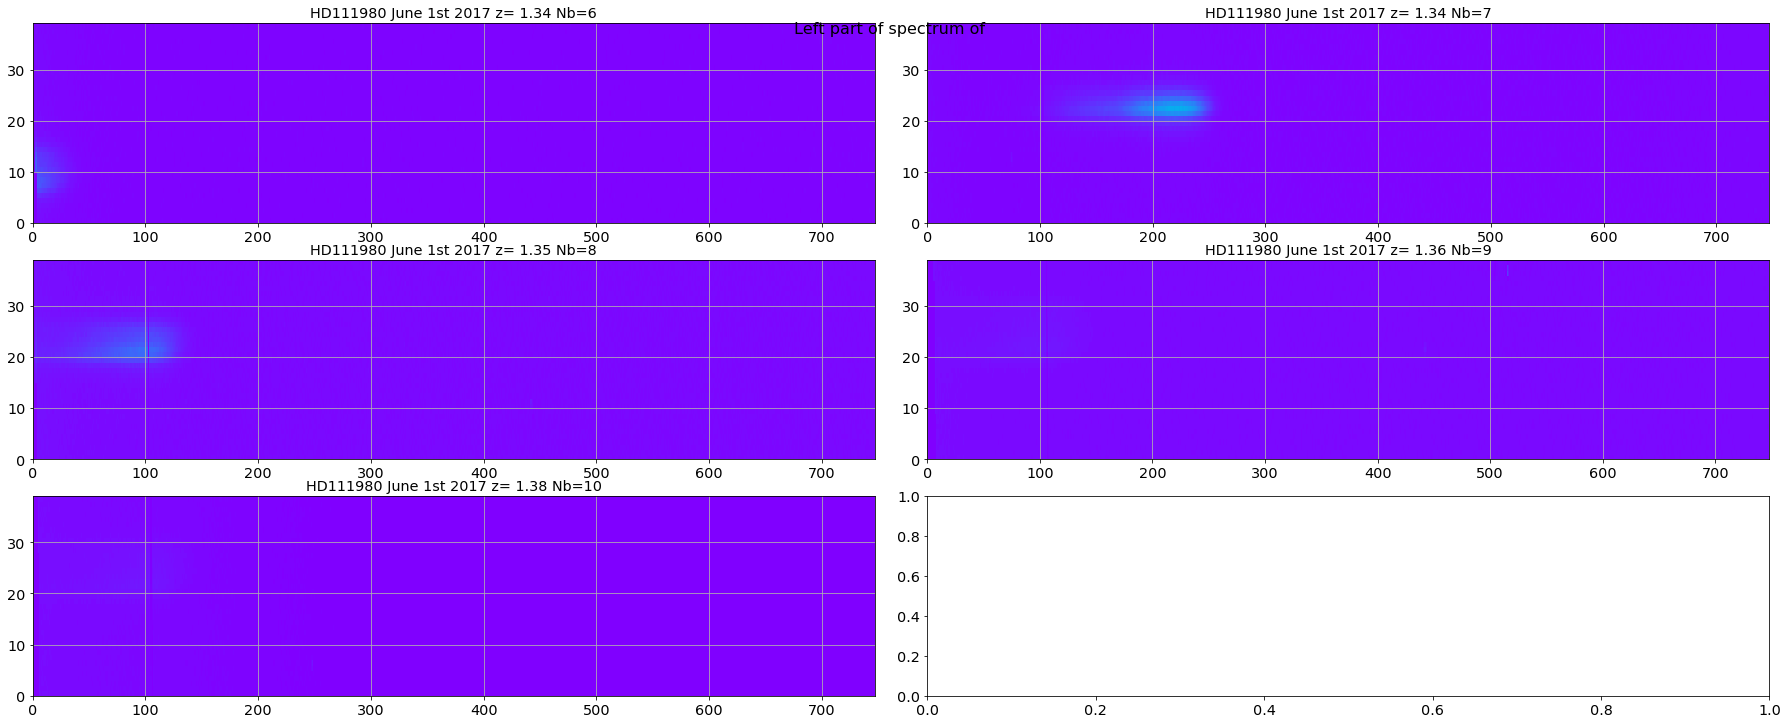

In [53]:
ShowLeftOrder(all_images,thex0,they0,all_titles,object_name,all_expo,dir_top_images)

In [54]:
def CleanBadPixels(spectraUp,spectraDown):
    
    Clean_Up= []
    Clean_Do = []
    Clean_Av = []
    eps=25.   # this is the minumum background Please check
    NBSPEC=len(spectraUp)
    for index in np.arange(0,NBSPEC):
        s_up=spectraUp[index]
        s_do=spectraDown[index]
    
        index_up=np.where(s_up<eps)
        index_do=np.where(s_do<eps)
        
        s_up[index_up]=s_do[index_up]
        s_do[index_do]=s_up[index_do]
        s_av=(s_up+s_do)/2.
        
        Clean_Up.append(s_up)
        Clean_Do.append(s_do)
        Clean_Av.append(s_av)
        
    return Clean_Up, Clean_Do,Clean_Av 

In [55]:
Clean_Up, Clean_Do,Clean_Av=CleanBadPixels(thespectraUp,thespectraDown) 

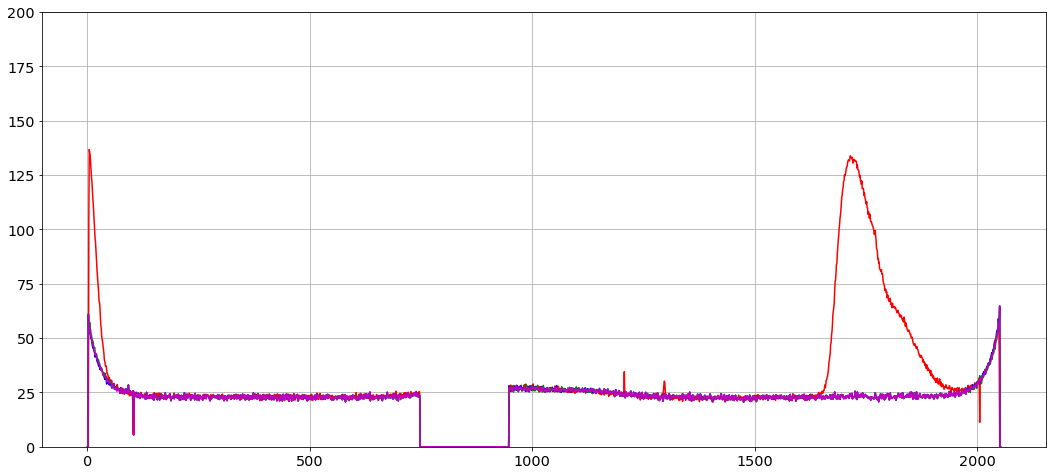

In [56]:
sel=0
plt.figure(figsize=(18,8))
plt.plot(thespectra[sel],'r-') 
plt.plot(Clean_Up[sel],'b-') 
plt.plot(Clean_Do[sel],'g-')
plt.plot(Clean_Av[sel],'m-')
plt.grid(True)
plt.ylim(0,200.)
figfilename=os.path.join(dir_top_images,'bckg_sample.pdf')
plt.savefig(figfilename) 

In [57]:
def ShowLongitBackground(spectra,spectraUp,spectraDown,spectraAv,all_titles,object_name,dir_top_images):
    """
    Show the background to be removed to the spectrum
    """
    NBSPEC=len(spectra)
    MAXIMGROW=int(NBSPEC/NBIMGPERROW)+1
    
   
    
    f, axarr = plt.subplots(MAXIMGROW,NBIMGPERROW,figsize=(25,5*MAXIMGROW))
    f.tight_layout()
    for index in np.arange(0,NBSPEC):
        ix=index%NBIMGPERROW
        iy=index/NBIMGPERROW
        axarr[iy,ix].plot(spectra[index],'r-')
        axarr[iy,ix].plot(spectraUp[index],'b-')
        axarr[iy,ix].plot(spectraDown[index],'g-')
        axarr[iy,ix].plot(spectraAv[index],'m-')
        axarr[iy,ix].set_title(all_titles[index])
        axarr[iy,ix].grid(True)
        axarr[iy,ix].set_ylim(0.,spectra[index][:1900].max()*1.2)
        axarr[iy,ix].text(1400.,spectra[index][:1900].max()*1.1, all_filt[index],verticalalignment='top', horizontalalignment='center',color='blue',fontweight='bold', fontsize=20)
    title='Longitudinal background Up/Down'.format(object_name)
    plt.suptitle(title,size=16)
    
    figfilename=os.path.join(dir_top_images,'background_longprofile.pdf')
    plt.savefig(figfilename)  
    

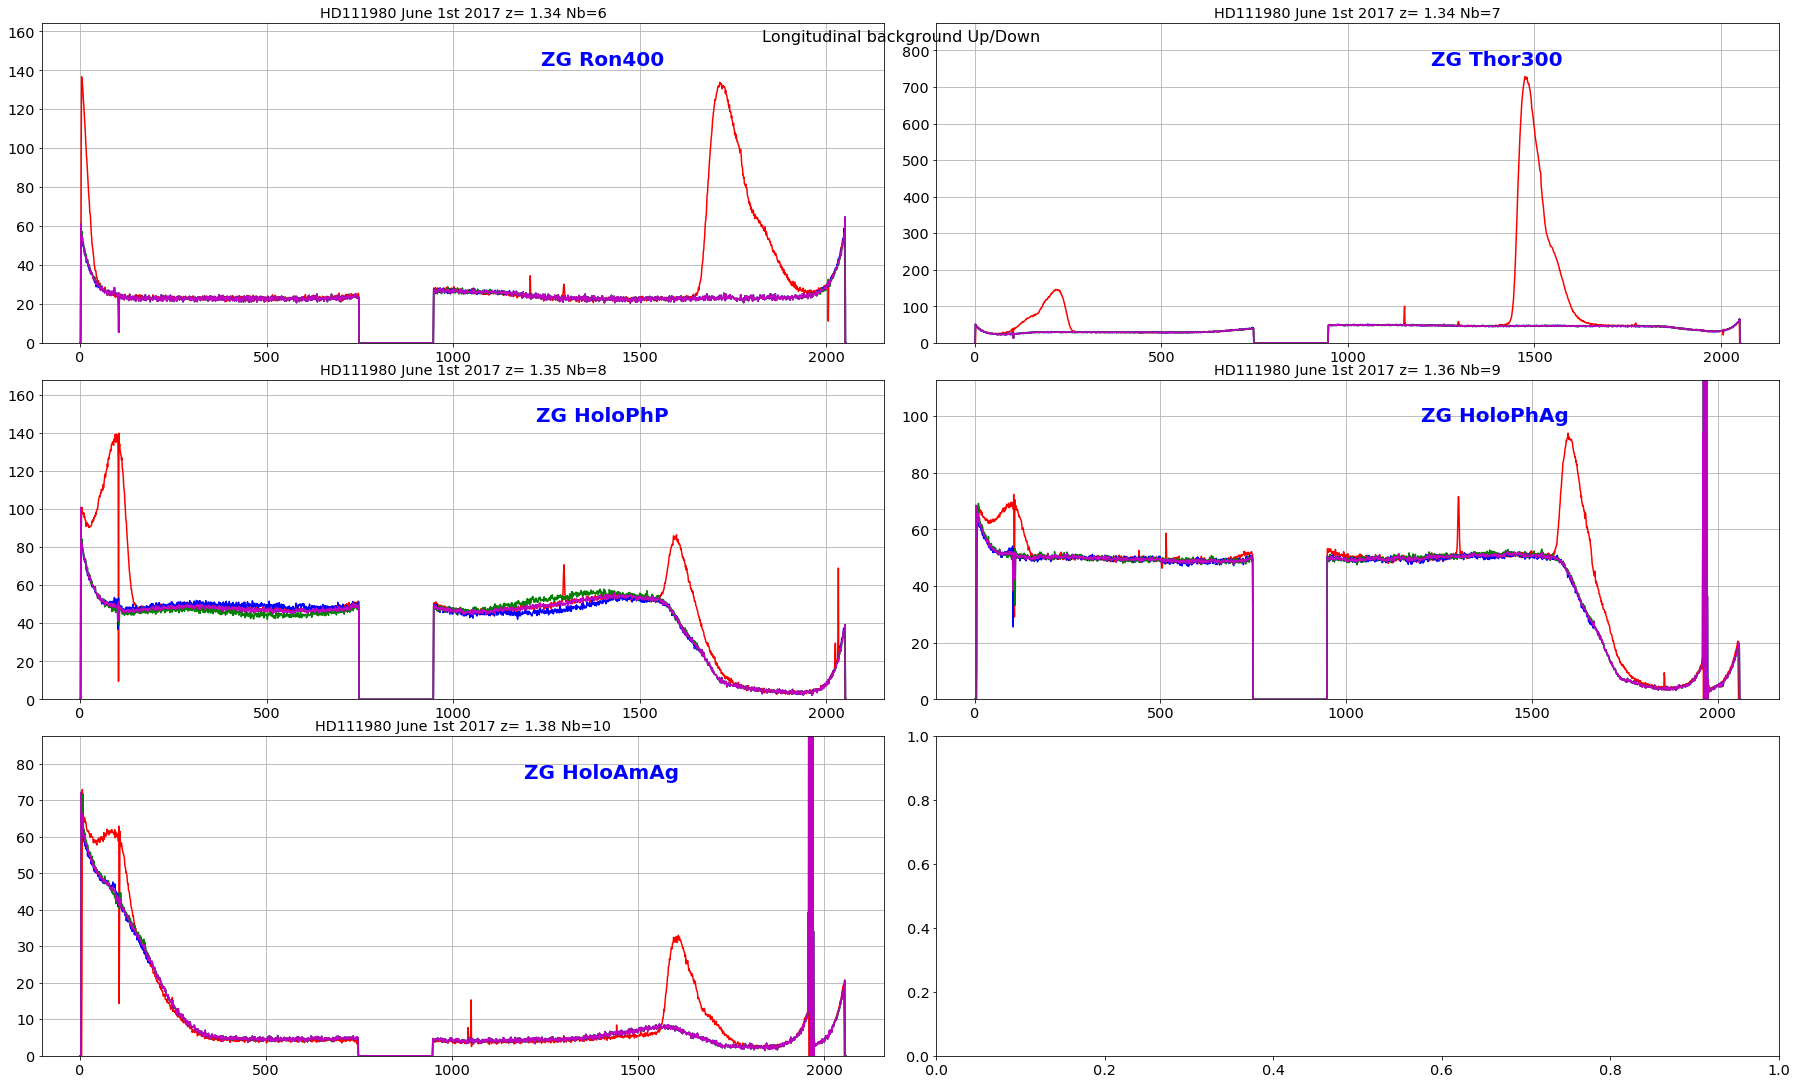

In [58]:
ShowLongitBackground(thespectra,Clean_Up,Clean_Do,Clean_Av,all_titles,object_name,dir_top_images)

In [59]:
def CorrectSpectrumFromBackground(spectra, background):
    """
    Background Subtraction
    """
    NBSPEC=len(spectra)
        
    corrected_spectra = []
    
    for index in np.arange(0,NBSPEC):
        corrspec=spectra[index]-background[index]
        corrected_spectra.append(corrspec)
    return corrected_spectra

In [60]:
thecorrspectra=CorrectSpectrumFromBackground(thespectra,Clean_Av)

In [61]:
%%cython
import numpy as np
import matplotlib.pyplot as plt
import os

def ShowSpectrumProfile(spectra,all_titles,object_name,dir_top_images,all_filt):
    """
    ShowSpectrumProfile: Show the raw images without background subtraction
    =====================
    """
    NBIMGPERROW=2
    NBSPEC=len(spectra)
    MAXIMGROW=int(NBSPEC/NBIMGPERROW)+1
    #MaxY= [150.,150.,150.,5000.,1500.,1000.,5000.,5000.,500.,150.]
    
    f, axarr = plt.subplots(MAXIMGROW,NBIMGPERROW,figsize=(25,5*MAXIMGROW))
    f.tight_layout()
    for index in np.arange(0,NBSPEC):
        ix=index%NBIMGPERROW
        iy=index/NBIMGPERROW
        axarr[iy,ix].plot(spectra[index],'r-')
        axarr[iy,ix].set_title(all_titles[index])
        axarr[iy,ix].grid(True)
        axarr[iy,ix].set_ylim(0.,spectra[index][:1900].max()*1.2)
        axarr[iy,ix].text(1000.,spectra[index][:1900].max()*1.1, all_filt[index],verticalalignment='top', horizontalalignment='center',color='blue',fontweight='bold', fontsize=20)
    
    title='Spectrum 1D profile and background Up/Down for {}'.format(object_name)
    plt.suptitle(title,size=16)
    
    figfilename=os.path.join(dir_top_images,'correctedspectrum_profile.pdf')
    plt.savefig(figfilename)  
    

#### Here below, we plot the latera (up and down ) background which has not been subtracted
For me the background remains flat and at zero


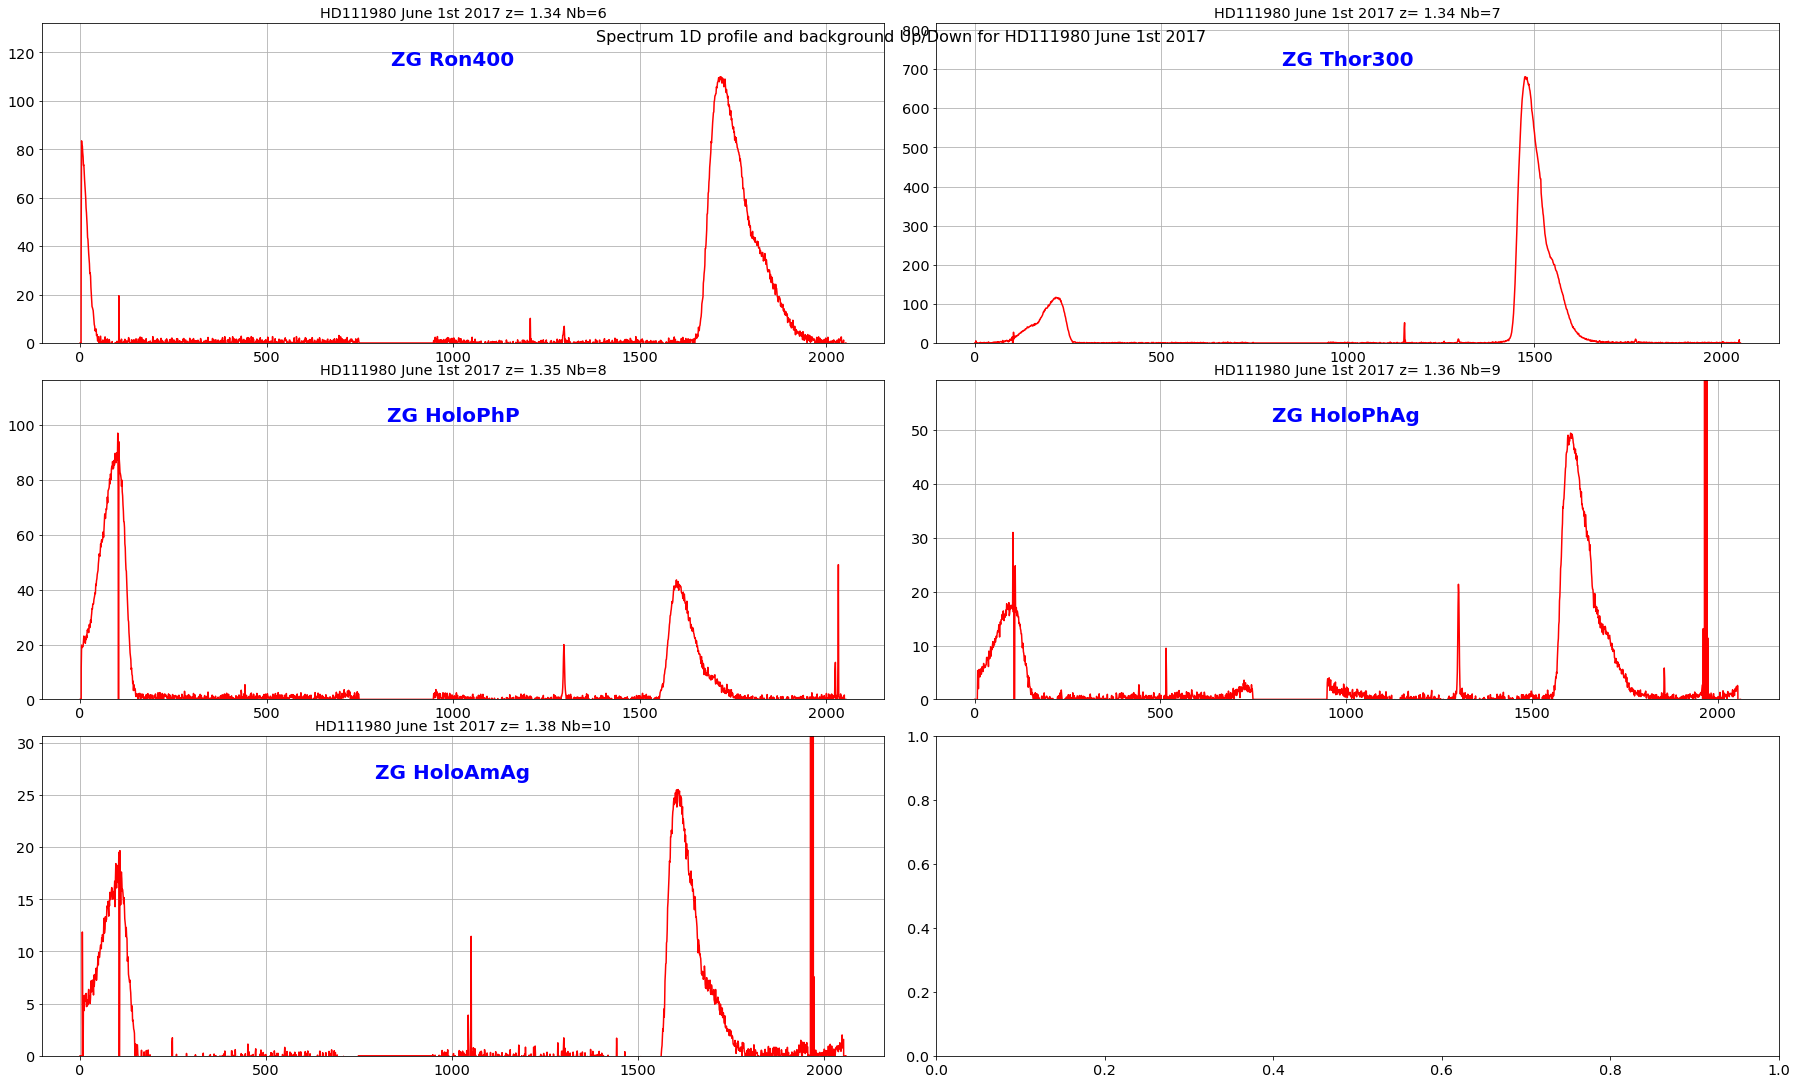

In [62]:
ShowSpectrumProfile(thecorrspectra,all_titles,object_name,dir_top_images,all_filt)

In [63]:
%%cython
import numpy as np
import matplotlib.pyplot as plt
import os

def ShowSpectrumProfile2(spectra,all_titles,object_name,dir_top_images,all_filt):
    """
    ShowSpectrumProfile: Show the raw images without background subtraction
    =====================
    """
    NBIMGPERROW=2
    NBSPEC=len(spectra)
    MAXIMGROW=int(NBSPEC/NBIMGPERROW)+1
    #MaxY= [150.,150.,150.,5000.,1500.,1000.,5000.,5000.,500.,150.]
    
    f, axarr = plt.subplots(MAXIMGROW,NBIMGPERROW,figsize=(25,5*MAXIMGROW))
    f.tight_layout()
    for index in np.arange(0,NBSPEC):
        ix=index%NBIMGPERROW
        iy=index/NBIMGPERROW
        axarr[iy,ix].plot(spectra[index],'r-')
        axarr[iy,ix].set_title(all_titles[index])
        axarr[iy,ix].grid(True)
        axarr[iy,ix].set_ylim(0.,spectra[index][:1900].max()*1.2)
        axarr[iy,ix].set_xlim(1000.,2000.)
        axarr[iy,ix].text(1400.,spectra[index][:1900].max()*1.1, all_filt[index],verticalalignment='top', horizontalalignment='center',color='blue',fontweight='bold', fontsize=20)
    
    title='Spectrum 1D profile and background Up/Down for {}'.format(object_name)
    plt.suptitle(title,size=16)
    
    figfilename=os.path.join(dir_top_images,'correctedspectrum_profile2.pdf')
    plt.savefig(figfilename)  
    

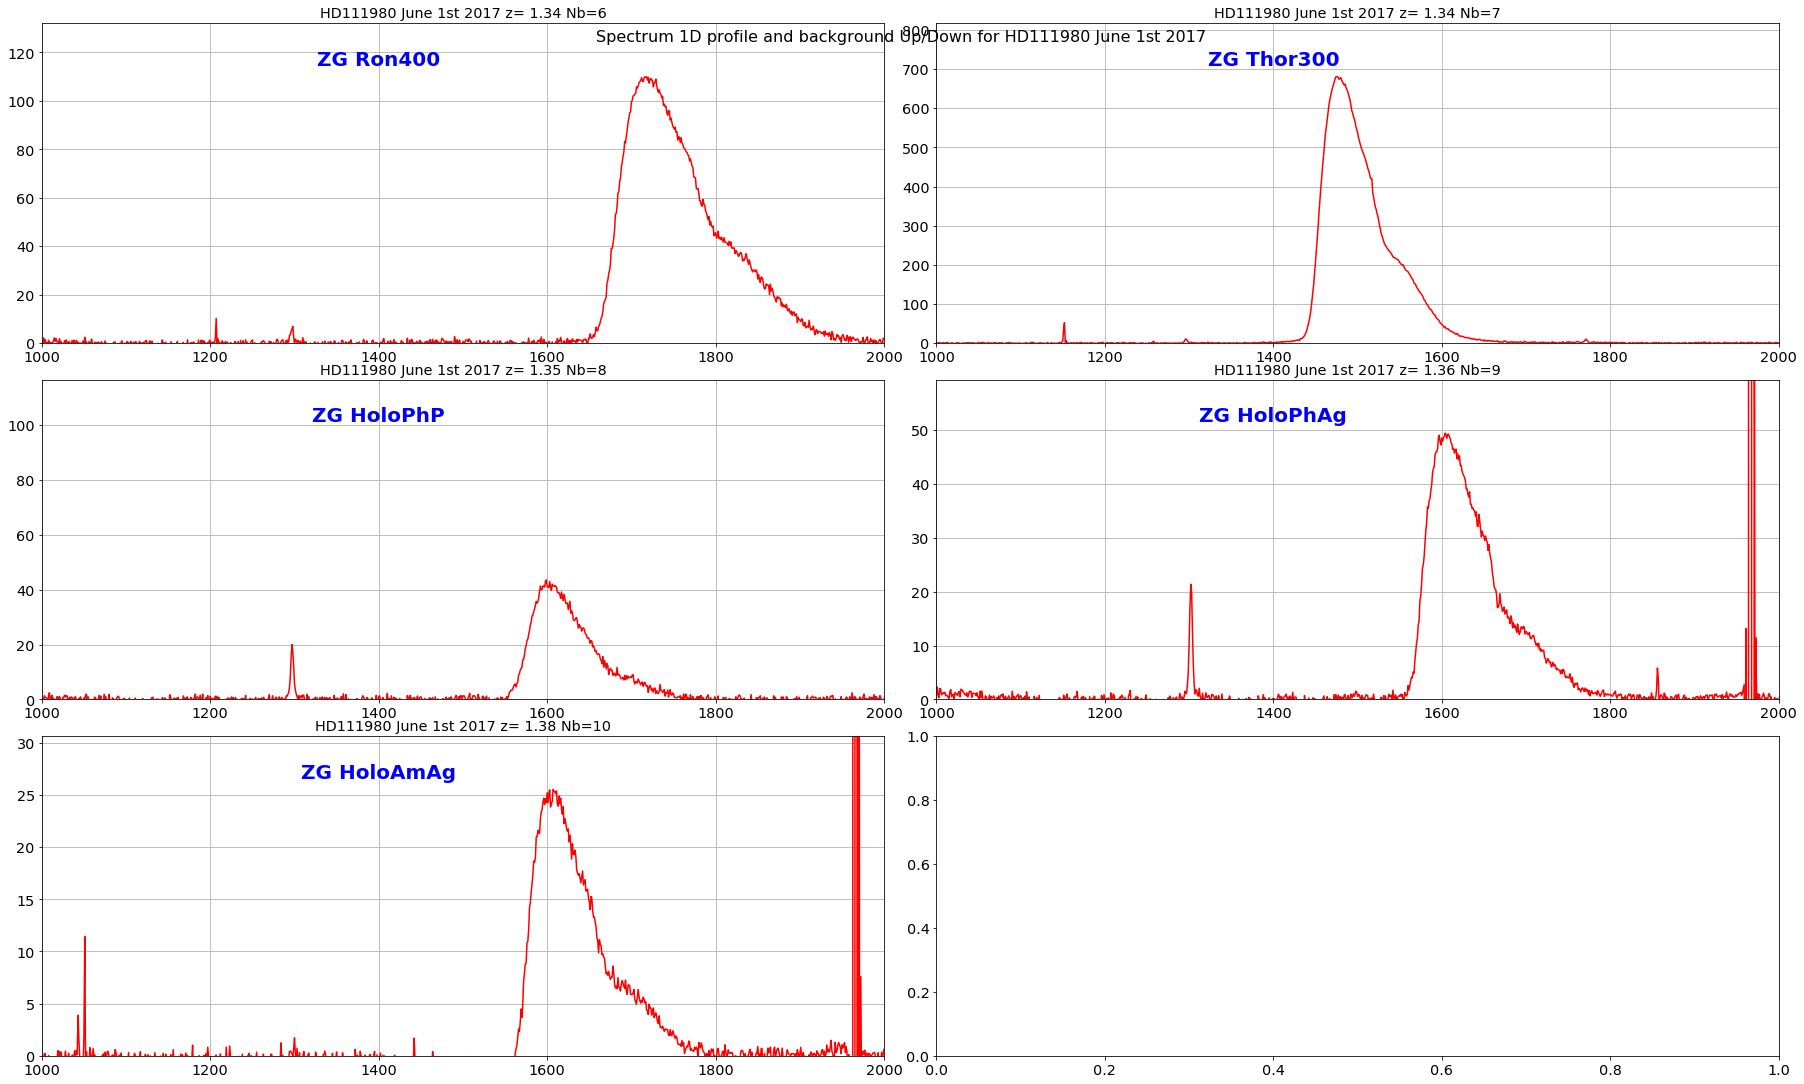

In [64]:
ShowSpectrumProfile2(thecorrspectra,all_titles,object_name,dir_top_images,all_filt)

## Ratio between amplitudes

In [65]:
%%cython
import numpy as np
import matplotlib.pyplot as plt
import os

def SpectrumAmplitudeRatio(spectra):
    """
    SpectrumAmplitudeRatio: ratio of amplitudes
    =====================
    """
    ratio_list= []
    
    NBSPEC=len(spectra)
    
    for index in np.arange(0,NBSPEC):
       
        max_right=spectra[index][700:1900].max()
        max_left=spectra[index][:700].max()
        
        ratio=max_right/max_left
        ratio_list.append(ratio) 
        
    return ratio_list

In [66]:
ratio_of_maxamplitudes=SpectrumAmplitudeRatio(thecorrspectra)

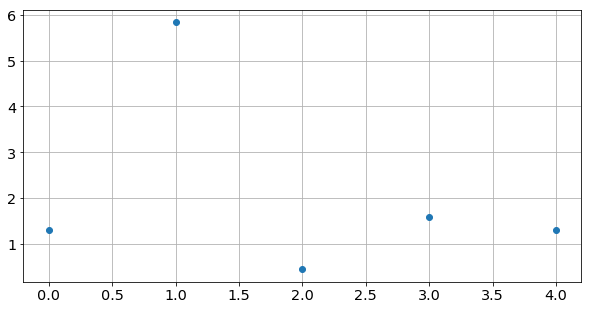

In [67]:
plt.figure(figsize=(10,5))
plt.plot(ratio_of_maxamplitudes,'o')
plt.grid()

In [68]:
print all_filt

['ZG Ron400', 'ZG Thor300', 'ZG HoloPhP', 'ZG HoloPhAg', 'ZG HoloAmAg']


## Example of a single spectrum

In [69]:
sel=3
spectrum_sel=thecorrspectra[sel]

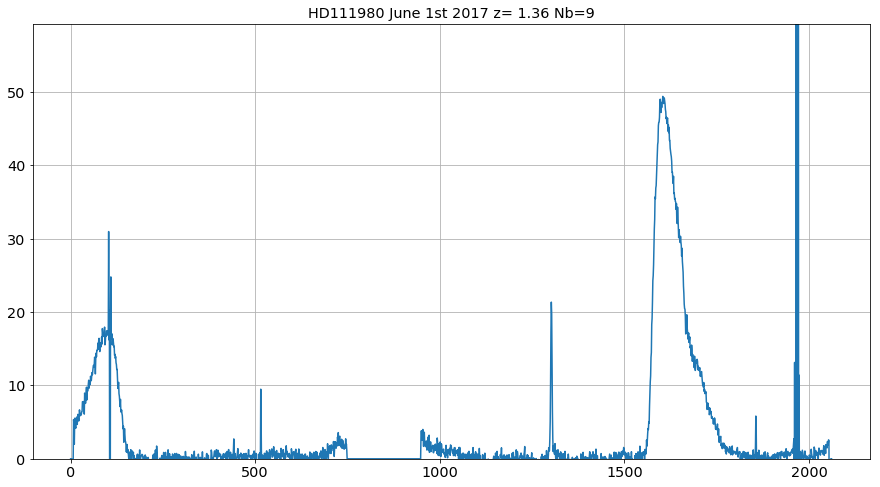

In [70]:
plt.figure(figsize=(15,8))
plt.plot(spectrum_sel)
title=all_titles[sel]
plt.title(title)
plt.grid(True)
plt.ylim(0,spectrum_sel[:1900].max()*1.2)
figfilename=os.path.join(dir_top_images,'singlespec_sample.pdf')
plt.savefig(figfilename) 

## Extract FWHM profiles

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


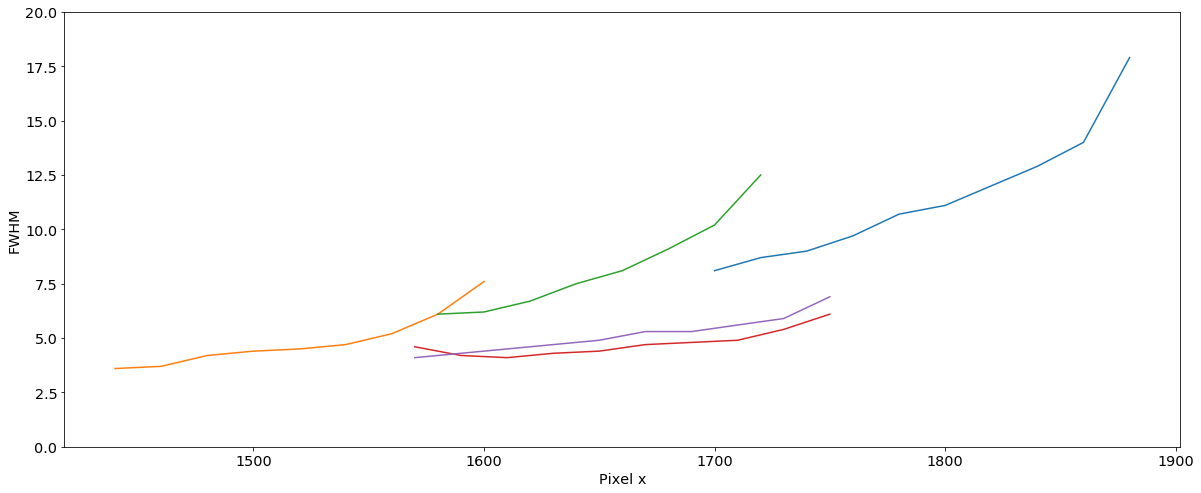

In [103]:
%load_ext autoreload
%autoreload 2
from fwhm_profiles import *

theprofiles = FWHMProfiles(all_images,thex0,they0,all_expo,all_titles,object_name,dir_top_images,all_filt,width_to_stack=20,left_edges=[1700,1300,1580,1550,1550],right_edges=[2000,2000,2000,2000,2000])

/opt/local/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/matplotlib/transforms.py:661: RuntimeWarning: invalid value encountered in absolute
  inside = ((abs(dx0 + dx1) + abs(dy0 + dy1)) == 0)


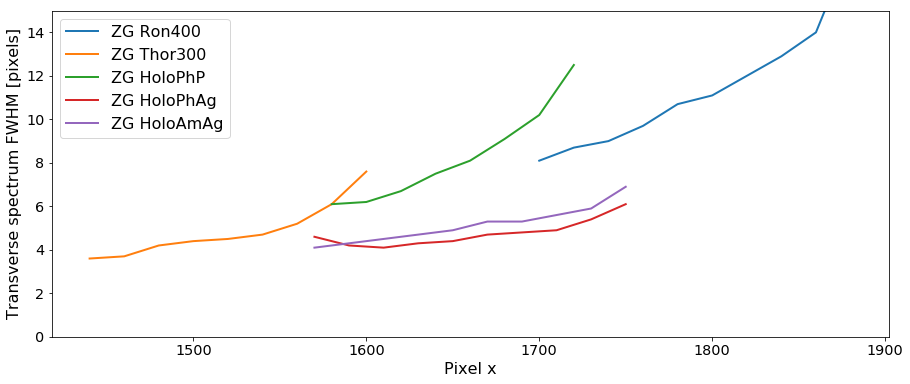

In [104]:
fig = plt.figure(figsize=(15,6))
for i in range(5):
    profile = theprofiles[i]
    plt.plot(profile[0],profile[1],label=all_filt[i],lw=2)
plt.xlabel('Pixel x',fontsize=16)
plt.ylabel('Transverse spectrum FWHM [pixels]',fontsize=16)
plt.ylim([0,15])
plt.legend(fontsize=16)
figfilename=os.path.join(dir_top_images,'fwhm_profiles.pdf')
plt.savefig(figfilename, bbox_inches='tight', rasterized=True, dpi=300)  
plt.show()

ZG Ron400
Grating plate center at x0 = 1024.0 and y0 = 1024.0 with average tilt of -0.3 degrees
N = 401.60 +/- 1.14 grooves/mm
Hologram center at x0 = 741.0 and y0 = 741.0 with average tilt of -0.3 degrees
Plate center at x0 = 774.0 and y0 = 690.7 with average tilt of -0.3 degrees
Order  0 position at x0 = 475.4 and y0 = 742.3
Order +1 position at x0 = 1006.6 and y0 = 739.7
Distance between the orders: 531.21 pixels (12.75 mm)
-----------------------------------------------------
ZG Thor300
Grating plate center at x0 = 1024.0 and y0 = 1024.0 with average tilt of -0.6 degrees
N = 299.43 +/- 0.88 grooves/mm
Hologram center at x0 = 1398.0 and y0 = 1264.0 with average tilt of -0.6 degrees
Plate center at x0 = 774.0 and y0 = 690.7 with average tilt of -0.6 degrees
Order  0 position at x0 = 1132.4 and y0 = 1266.7
Order +1 position at x0 = 1663.6 and y0 = 1261.3
Distance between the orders: 531.21 pixels (12.75 mm)
-----------------------------------------------------
ZG HoloPhP
Grating plate

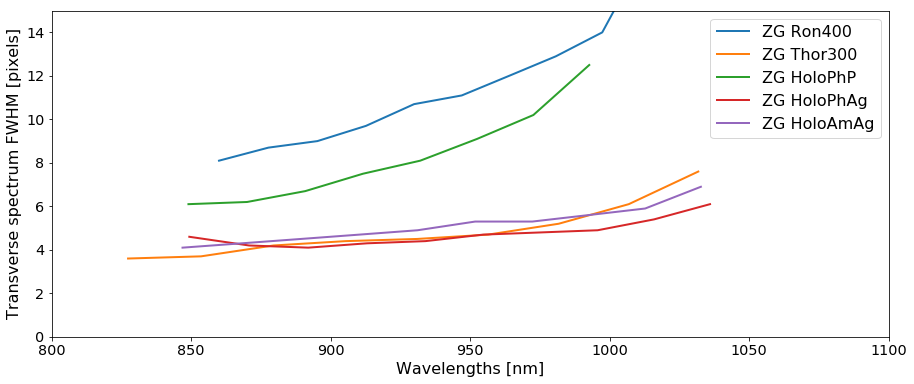

In [107]:
from scan_holo import *

fig, ax = plt.subplots(1,1,figsize=(15,6))
for i in range(5):
    profile = theprofiles[i]
    print all_filt[i]
    holo = Hologram(all_filt[i].split()[1])
    print '-----------------------------------------------------'
    lambdas = holo.grating_pixel_to_lambda(np.array(profile[0]) -thex0[i] )      
    ax.plot(lambdas,profile[1],label=all_filt[i],lw=2)
#plot_atomic_lines(ax,np.max(profile[1])*1.2,redshift=0,atmospheric_lines=True)
plt.xlabel('Wavelengths [nm]',fontsize=16)
plt.ylabel('Transverse spectrum FWHM [pixels]',fontsize=16)
plt.ylim([0,15])
plt.xlim([800,1100])
plt.legend(fontsize=16)
figfilename=os.path.join(dir_top_images,'fwhm_profiles.pdf')
plt.savefig(figfilename, bbox_inches='tight', rasterized=True, dpi=300)  
plt.show()

### prepare outputfilename

In [73]:
newfullfilenames=[]
for idx,file in np.ndenumerate(sorted_files):
    short_infilename=file.split("/")[2]
    short_partfilename=re.findall('^rotimg_(.*)',short_infilename)
    short_outfilename='finalSpectra_'+short_partfilename[0]
    newfullfilename=os.path.join(outputdir,short_outfilename)
    newfullfilenames.append(newfullfilename)

In [74]:
newfullfilenames

['./spectrum_fitsspec/finalSpectra_20170601_006.fits',
 './spectrum_fitsspec/finalSpectra_20170601_007.fits',
 './spectrum_fitsspec/finalSpectra_20170601_008.fits',
 './spectrum_fitsspec/finalSpectra_20170601_009.fits',
 './spectrum_fitsspec/finalSpectra_20170601_010.fits']

### Save outputfilename

In [75]:
#
#  New fashion to save a binary table outside the primary header
#
for idx,file in np.ndenumerate(newfullfilenames):
    primhdu = fits.PrimaryHDU(header=all_header[idx[0]])   # make an primary HDU without data
    
    col1=fits.Column(name='RawLeftSpec',format='E',array=spectra_left[idx[0]])
    col2=fits.Column(name='RawRightSpec',format='E',array=spectra_right[idx[0]])
    cols=fits.ColDefs([col1,col2])
    
    tbhdu = fits.BinTableHDU.from_columns(cols)     # new binary table HDU
    thdulist = fits.HDUList([primhdu, tbhdu])
    
    thdulist.writeto(file,clobber=True)

NameError: name 'spectra_left' is not defined